In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = '/content/drive/My Drive/flickr8k.zip'
extract_path = '/content/extracted_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import re
from tqdm.notebook import tqdm

In [ ]:
dataset_path = "/content/extracted_data"
dataset_images_path = dataset_path + "/Images/"

In [ ]:
import os
extract_path = '/content/extracted_data/'

with open(os.path.join(extract_path, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
images_captions_dict = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in images_captions_dict:
        images_captions_dict[image_id] = []
    images_captions_dict[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
def preprocess_captions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

preprocess_captions(images_captions_dict)

In [ ]:
all_captions = []
for key in images_captions_dict:
    for caption in images_captions_dict[key]:
        all_captions.append(caption)
len(all_captions)

40456

In [ ]:
#dont run for epoch training

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm

extract_path = '/content/extracted_data/'
directory = os.path.join(extract_path, 'Images')

base_model = InceptionV3(weights='imagenet')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
features = {}

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    img = image.load_img(img_path, target_size=(299, 299))  # Resize the image to (299, 299)
    img = image.img_to_array(img)
    img = preprocess_input(img)

    img = np.expand_dims(img, axis=0)
    feature = feature_extractor.predict(img, verbose = 0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

np.save('image_features.npy', features)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
import pickle
WORKING_DIR = '/content/drive/MyDrive/'
pickle.dump(features, open(os.path.join(WORKING_DIR, 'I_features.pkl'), 'wb'))

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)
vocab_size

8485

In [ ]:
image_ids = list(images_captions_dict.keys())
len(image_ids)

8092

In [ ]:
# Function for crash prevention
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Image Feature Input Layer
image_input = Input(shape=(2048,))
image_dropout = Dropout(0.2)(image_input)
image_dense = Dense(256, activation='relu')(image_dropout)

# Sequence Input Layer
sequence_input = Input(shape=(max_length))
sequence_embedding = Embedding(vocab_size, 256, mask_zero=True)(sequence_input)
sequence_dropout = Dropout(0.2)(sequence_embedding)
sequence_lstm = LSTM(256)(sequence_dropout)

# Decoder
decoder_concat = add([image_dense, sequence_lstm])
decoder_dense = Dense(128, activation='relu')(decoder_concat)

# Output Layer
output = Dense(vocab_size, activation='softmax')(decoder_dense)

model = Model(inputs=[image_input, sequence_input], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=Adam())

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 256)              2172160   ['input_4[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_3[0][0]']             
                                                                                            

In [ ]:
# Training done till 15 epoch in batches of 3 --> +7 --> +5 == 15
epochs = 5
batch_size = 32
steps = len(image_ids) // batch_size

for i in range(epochs):
    generator = data_generator(image_ids, images_captions_dict, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

252/252 [==============================] - 69s 274ms/step - loss: 2.5513


In [ ]:
model.save('/content/drive/MyDrive/inception_15.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle
WORKING_DIR = '/content/drive/MyDrive/'

with open(os.path.join(WORKING_DIR, 'I_features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/inception_model_15.h5')

In [ ]:
# Function for conversion of output vector array to text/word
def idx2word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None

In [ ]:
# Predicts the sequence of the captions given an image
def predict_caps(model, image, tokenizer, max_length):
  in_text = 'startseq'
  for i in range(max_length):
      sequence = tokenizer.texts_to_sequences([in_text])[0]
      sequence = pad_sequences([sequence], max_length)
      yhat = model.predict([image, sequence], verbose=0)
      yhat = np.argmax(yhat) #
      word = idx2word(yhat, tokenizer)
      if word is None:
          break
      in_text += " " + word
      if word == 'endseq':
          break

  return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def show_image(image_name):
  image_id = image_name.split('.')[0]
  img_path = os.path.join(extract_path, "Images", image_name)
  image = Image.open(img_path)
  plt.imshow(image)

In [ ]:
def generate_caps(image_name):
  image_id = image_name.split('.')[0]
  show_image(image_name)
  y_pred = predict_caps(model, features[image_id], tokenizer, max_length)
  print('Predicted Caption:')
  print(y_pred)

  captions = images_captions_dict[image_id]
  print('Actual Captions:')
  for caption in captions:
      print(caption)

In [ ]:
imgpath = "3431860810_44277cd360"

Predicted Caption:
startseq two dogs play in the sand endseq
Actual Captions:
startseq beige dog with collar looks on as brown dog swims in the water endseq
startseq curly coated dog looking at another dog in the water endseq
startseq curly haired dog is standing on beach while staring at dog in deep water endseq
startseq "a white curly haired dog is wearing harness and watching another black and brown dog in the water ." endseq
startseq wooly dog on beach looks toward another dog in the water endseq


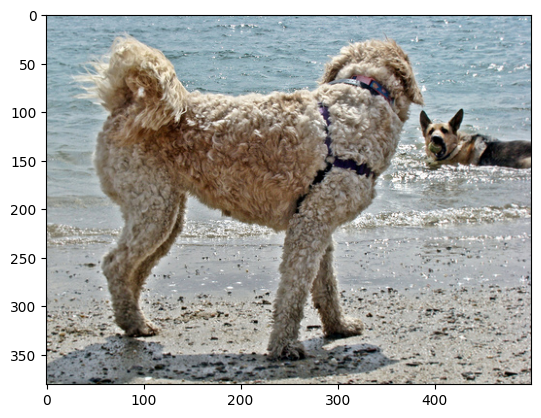

In [ ]:
generate_caps(imgpath+'.jpg')

Predicted Caption:
startseq two children play with red fingerpaints endseq
Actual Captions:
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


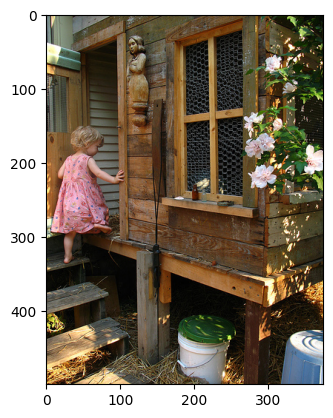

In [ ]:
generate_caps("1000268201_693b08cb0e.jpg")

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
scores =[]
for i in image_ids[-10:-5]:
  actual= images_captions_dict[i]
  predicted = predict_caps(model, features[i], tokenizer, max_length)
  scores.append(sentence_bleu(actual,predicted))

mean= sum(scores)/len(scores)
mean

0.5989429574282825